In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bibliotheque import *
import tqdm
%matplotlib inline

In [3]:
root = '/crnldata/'
save_presentation = False
save_cycles_spindled = False

In [4]:
def load_df():
    spindle_file = root + 'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/df_analyse/spindles_N2.xlsx'
    rsp_cycle_file = root + 'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/df_analyse/resp_features.xlsx'
    df_cycles = pd.read_excel(rsp_cycle_file).drop(columns = 'Unnamed: 0').loc[:,['cycle_num','inspi_index','expi_index','inspi_time','expi_time','insp_duration','exp_duration','cycle_duration','cycle_freq']]
    spindles = pd.read_excel(spindle_file).drop(columns = 'Unnamed: 0')
    end_cycles = []
    for cycle in range(df_cycles.shape[0]):
        end_resp = df_cycles.loc[cycle, 'inspi_time'] + df_cycles.loc[cycle, 'cycle_duration']
        end_cycles.append(end_resp)
    df_cycles['end_time'] = end_cycles
    df_cycles
    
    return df_cycles , spindles

In [5]:
df_cycles , spindles = load_df()

In [6]:
df_cycles

,cycle_num,inspi_index,expi_index,inspi_time,expi_time,insp_duration,exp_duration,cycle_duration,cycle_freq,end_time
0,0,156,430,0.609375,1.679688,1.070312,1.890625,2.960938,0.337731,3.570312
1,1,914,1199,3.570312,4.683594,1.113281,2.027344,3.140625,0.318408,6.710938
2,2,1718,1983,6.710938,7.746094,1.035156,2.101562,3.136719,0.318804,9.847656
3,3,2521,2791,9.847656,10.902344,1.054688,2.085938,3.140625,0.318408,12.988281
4,4,3325,3549,12.988281,13.863281,0.875000,1.660156,2.535156,0.394453,15.523438
...,...,...,...,...,...,...,...,...,...,...
3067,3067,2261369,2261613,8833.472656,8834.425781,0.953125,1.765625,2.718750,0.367816,8836.191406
3068,3068,2262065,2262310,8836.191406,8837.148438,0.957031,1.812500,2.769531,0.361072,8838.960938
3069,3069,2262774,2263019,8838.960938,8839.917969,0.957031,1.972656,2.929688,0.341333,8841.890625
3070,3070,2263524,2263806,8841.890625,8842.992188,1.101562,1.925781,3.027344,0.330323,8844.917969


In [7]:
spindles

,stage,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,N2,59.062500,59.421875,59.949219,0.886719,50.552506,9.198861,1.681068,0.273213,13.133185,9,0.403509,Fp2-C4,0
1,N2,61.679688,62.152344,62.363281,0.683594,45.307265,11.034409,2.248550,0.552724,12.831217,9,0.687500,Fp2-C4,0
2,N2,65.433594,65.742188,66.015625,0.582031,44.304907,10.309570,2.206761,0.374857,13.944192,8,0.526667,Fp2-C4,0
3,N2,67.644531,67.765625,68.296875,0.652344,48.667588,11.655442,2.139001,0.361876,14.613895,8,0.184524,Fp2-C4,0
4,N2,87.617188,87.996094,88.328125,0.710938,50.774271,10.271449,1.864004,0.237175,13.915164,7,0.530055,Fp2-C4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3152,N2,8070.269531,8070.687500,8070.871094,0.601562,37.650290,8.835626,1.854641,0.254221,14.052198,6,0.690323,T3-O1,7
3153,N2,8292.859375,8293.003906,8293.625000,0.765625,38.533010,9.228405,1.740058,0.229788,13.896299,10,0.187817,T3-O1,7
3154,N2,8372.921875,8373.269531,8373.558594,0.636719,48.351797,10.112342,1.877038,0.283629,14.457036,9,0.542683,T3-O1,7
3155,N2,8390.382812,8390.726562,8391.035156,0.652344,70.508474,15.496380,2.465284,0.384927,13.893178,8,0.523810,T3-O1,7


In [8]:
spindles.mean()

/tmp/ipykernel_197372/1878247947.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  spindles.mean()


Start           4825.011148
Peak            4825.433698
End             4825.881427
Duration           0.870278
Amplitude         50.268975
RMS               10.826002
AbsPower           2.020097
RelPower           0.400623
Frequency         13.753528
Oscillations      11.050998
Symmetry           0.484405
IdxChannel         3.106430
dtype: float64

In [31]:
def which_cycle_find_spindle(spindles = spindles, df_cycles = df_cycles, save=save_cycles_spindled):
    spindles_times = spindles['Peak'].values
    loop = range(df_cycles.shape[0])
    loop = tqdm.tqdm(loop , desc = 'cycle rsp')

    count = []

    for cycle in loop:

        start = df_cycles.loc[cycle,'inspi_time']
        stop = df_cycles.loc[cycle,'end_time']
        
        for spindle_time in spindles_times:
            if spindle_time >= start and spindle_time < stop:
                count.append(cycle)
    cycles_with_spindle = pd.Series(count).unique()
    if save:
        np.save('../df_analyse/cycle_spindled', cycles_with_spindle)
    return cycles_with_spindle

In [32]:
cycles_spindled = which_cycle_find_spindle(spindles = spindles, df_cycles = df_cycles)

cycle rsp: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 3732.09it/s]


In [33]:
def count_spindles_phase_resp(nbins, spindles = spindles, df_cycles = df_cycles, cycle_spindled = cycles_spindled, save=save_presentation):
    spindles_times = spindles['Peak'].values
    
    loop = range(cycles_spindled.shape[0])
    loop = tqdm.tqdm(loop , desc = 'cycle rsp')
    count = []

    for i in loop:
        cycle = cycle_spindled[i]

        start = df_cycles.loc[cycle,'inspi_time']
        stop = df_cycles.loc[cycle,'end_time']

        phases_timings = np.linspace(start, stop, nbins + 1)

        for spindle_time in spindles_times:
            for i, phase_start in enumerate(phases_timings):
                if phase_start != phases_timings[-1]:
                    phase_stop = phases_timings[i + 1]
                    if spindle_time >= phase_start and spindle_time < phase_stop:
                        count.append(i)
                        
    phase_count = pd.Series(count).value_counts().reindex(np.arange(0,nbins))
    
    fig, ax = plt.subplots(figsize = (10,6))
    
    phase_count.plot.bar(ax=ax)
    ax.set_title(f'Count of spindles by resp phase bin')
    ax.set_ylabel('Count of spindles')
    ax.set_xlabel('Phase bin')
    ax.bar_label(ax.containers[0])
    if save:
        plt.savefig(f'../presentation/phase_{nbins}_bins_spindles')
    plt.show()
    
    return phase_count

cycle rsp: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1133/1133 [00:15<00:00, 74.83it/s]


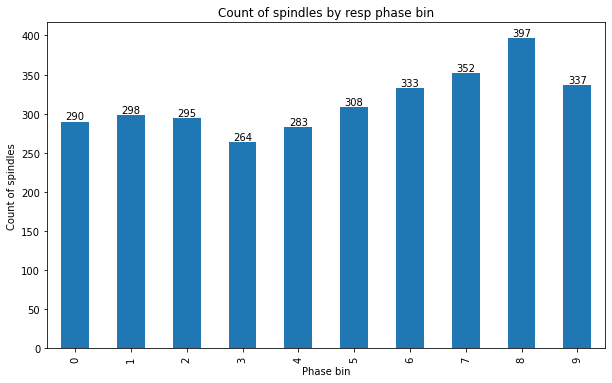

In [36]:
phase_count = count_spindles_phase_resp(nbins = 20)

In [11]:
def count_spindles_i_e_norm(spindles = spindles, df_cycles = df_cycles, save=save_presentation):
    spindles_times = spindles['Peak'].values
    loop = range(df_cycles.shape[0])
    loop = tqdm.tqdm(loop , desc = 'cycle rsp')

    count = []

    for cycle in loop:

        start = df_cycles.loc[cycle,'inspi_time']
        transition = df_cycles.loc[cycle , 'expi_time']
        stop = df_cycles.loc[cycle,'end_time']
        
        
        for spindle_time in spindles_times:
            if spindle_time >= start and spindle_time < transition:
                count.append('i')
            elif spindle_time >= transition and spindle_time < stop:
                count.append('e')
            else:
                count.append('Nothing in this cycle')
    count_ser = pd.Series(count).value_counts()
    count_norm = pd.DataFrame.from_dict({'i': round(count_ser.loc['i'] / df_cycles['cycle_freq'].mean() , 2) , 'e' : round(count_ser.loc['e'] / (1 - df_cycles['cycle_freq'].mean()), 2)}, orient = 'index')
    if save:
        count_norm.to_excel(f'../presentation/count_i_e_norm.xlsx')
    return count_norm

In [12]:
count_spindles_i_e_norm()

cycle rsp: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 3072/3072 [00:01<00:00, 1731.83it/s]


,0
i,2920.59
e,3285.22
